# Content and Objectives

- Show algorithm of Schmidl&Cox in OFDM

# Import

In [1]:
# importing
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 14}
plt.rc('font', **font)
plt.rc('text', usetex=0)

matplotlib.rc('figure', figsize=(12, 6) )

# Parameters

In [3]:
# NOTE: N_ofdm is number of carriers
N_ofdm = 256
N_used = 128

# length of cyclic prefix
L_G = 64

# parameter for fixed-lag correlation
L = N_ofdm//2 

# Get PN Sequence and Construct According OFDM Symbols

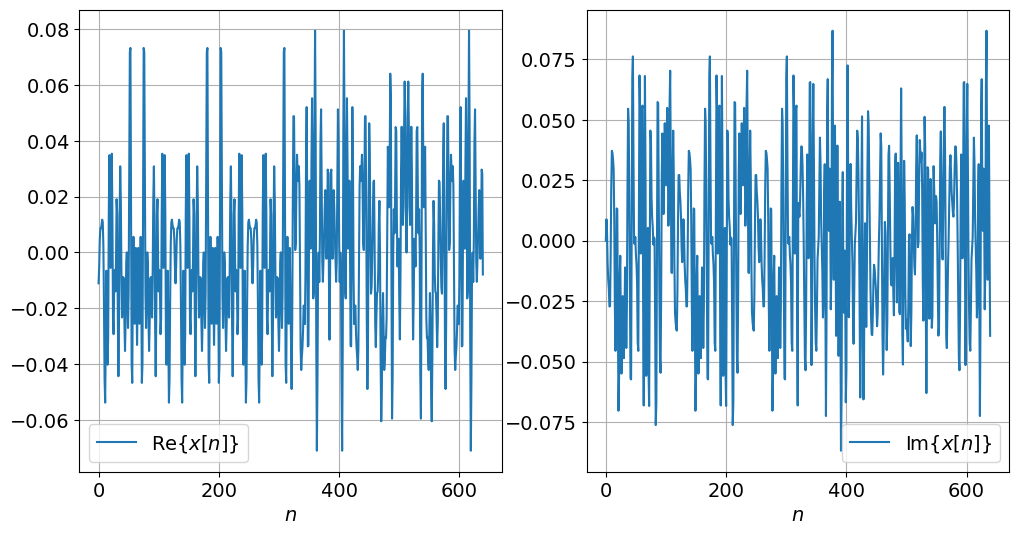

In [4]:
# PN seq. as bits
c_1 = signal.max_len_seq( 9 )[0][ : N_used//2 ]
c_1 = 1 - 2 * c_1

c_2 = signal.max_len_seq( 9 )[0][ : N_used ]
c_2 = 1 - 2 * c_2

# get OFDM signal 1
u_1 = np.zeros( N_ofdm )
u_1[ N_ofdm//2 - N_used//2 : N_ofdm//2 + N_used//2 : 2 ] = np.sqrt( 2 ) * c_1
s_1 = np.fft.ifft( np.fft.fftshift( u_1 ) )

# get OFDM signal 2
u_2 = np.zeros( N_ofdm )
u_2[ N_ofdm//2 - N_used//2 : N_ofdm//2 + N_used//2   : 1 ] = c_2
s_2 = np.fft.ifft( np.fft.fftshift( u_2 ) )

# get transmission signal 
x = np.concatenate( ( s_1[ -L_G : ], s_1, s_2[ -L_G : ], s_2 ) )

# show signal x
plt.subplot(121)
plt.plot(np.real(x), label='Re{$x[n]$}')
plt.xlabel('$n$')
plt.legend()
plt.grid(1)

plt.subplot(122)
plt.plot(np.imag(x), label='Im{$x[n]$}')
plt.xlabel('$n$')
plt.legend()
plt.grid(1)


In [5]:
# define SNR and obtain noise variance
Es_N0_dB = 100
sigma2 = 10**( - Es_N0_dB / 10 ) 

t_off = 400  # time offset
f_off = 17.4  # frequency offset 


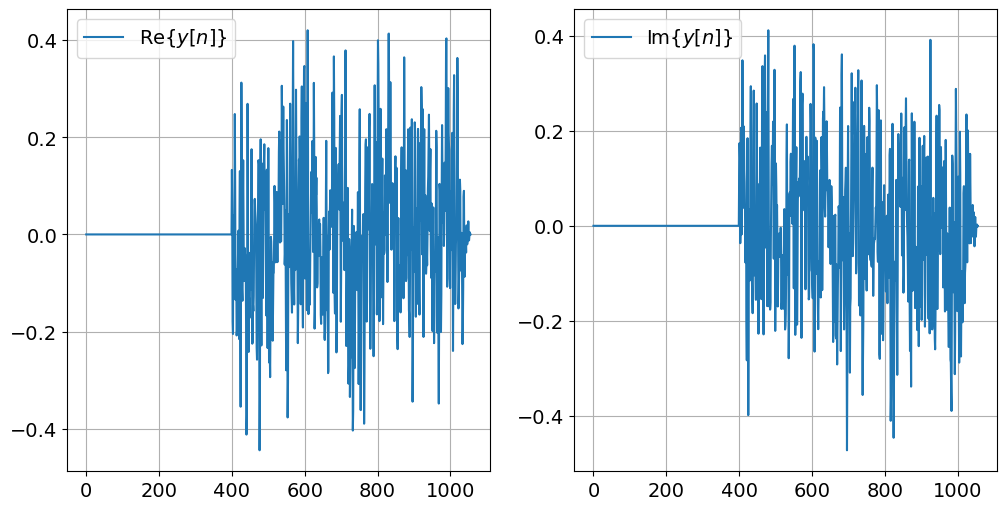

In [6]:
# apply channel
h_awgn = [ 1.0 ] 
h_multipath = np.linspace( 1, 0, L_G//2 ) * np.exp( 1j * np.random.uniform( -np.pi, np.pi, L_G//2 ) )  
h_multipath /= np.sqrt(np.mean(np.abs(h_multipath)**2))  # normalize

h = h_multipath

y = np.convolve(x, h, mode="full")
filter_delay = (len(h)-1) // 2
y = y[ filter_delay : ]  # Einschwingzeit entfernen

# frequency offset
y *= np.exp( 1j * 2 * np.pi * f_off * np.arange(len( y ))/N_ofdm )

# time offset
y = np.concatenate( (np.zeros((t_off,), dtype=complex), y))

# add noise to signals
y = y + np.sqrt( sigma2/2 ) * ( np.random.randn( len(y) ) + 1j * + np.random.randn( len(y) ) )


# show signal y
plt.subplot(121)
plt.plot(np.real(y), label='Re{$y[n]$}')
plt.legend()
plt.grid(1)

plt.subplot(122)
plt.plot(np.imag(y), label='Im{$y[n]$}')
plt.legend()
plt.grid(1)

# Determine and Plot Function $M(d)$

In [7]:
# find function P(d)
P_d = np.array( [ np.sum( y[ i + N_ofdm//2 : i + N_ofdm ] * np.conj( y [ i : i + N_ofdm//2 ] ) ) for i in range(len(y)-N_ofdm) ] )
R_d = np.array( [ np.sum( np.abs( y[ i + N_ofdm//2 : i + N_ofdm ] )**2 )  for i in range(len(y) - N_ofdm) ] )
M_d = np.abs( P_d / R_d )**2


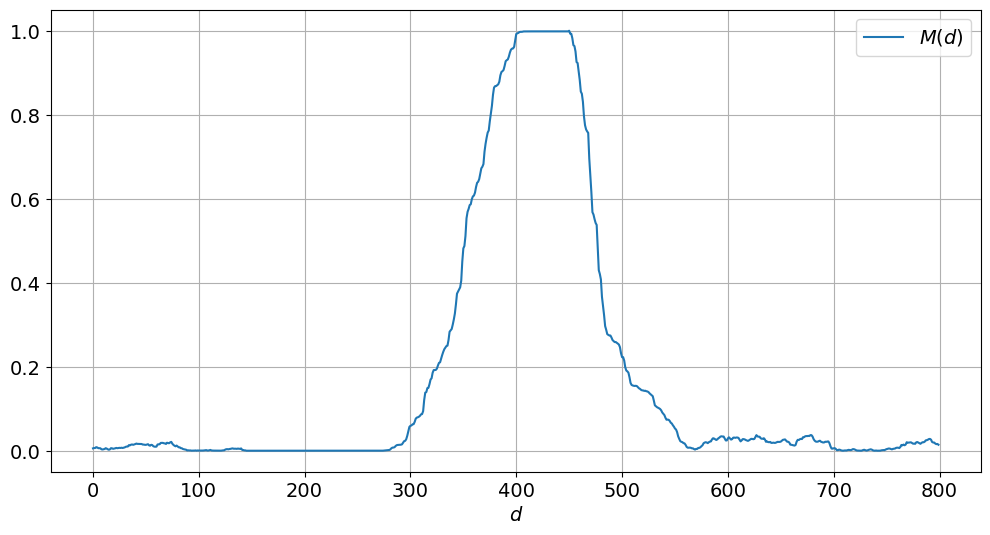

In [8]:

plt.plot( M_d, label='$M(d)$')
plt.xlabel('$d$')
plt.legend()
plt.grid(1)

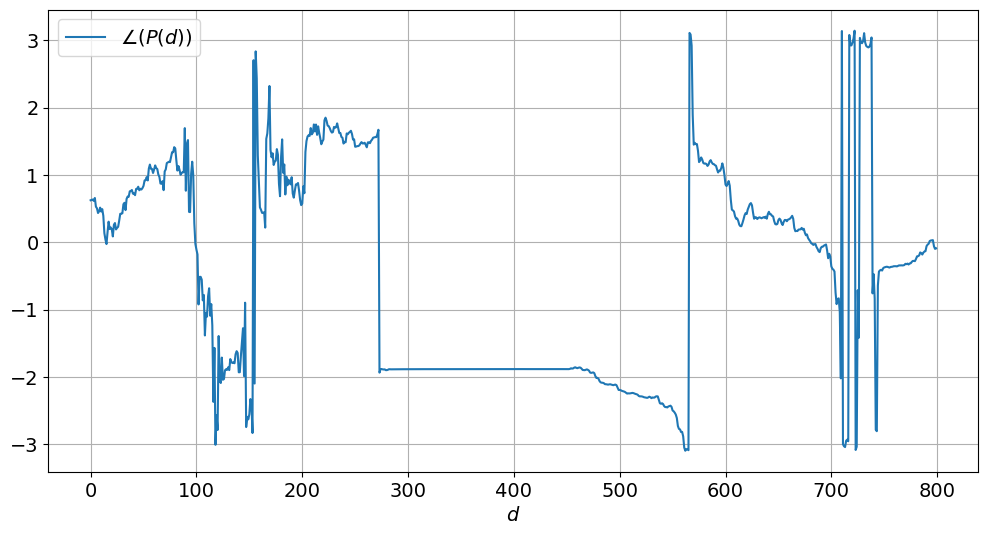

In [9]:
plt.plot( np.angle(  P_d ), label='$\\angle(P(d))$')
plt.xlabel('$d$')
plt.legend()
plt.grid(1)

In [10]:
# check if preamble is detected by verifying if correlation is large
threshold = 0.8
signal_detected = np.any( M_d > threshold)

print("Preamble identified." if signal_detected else "No preamel identified.")

Preamble identified.


In [11]:
if signal_detected:
    
    # get indices where threshold is exceeded and add L_G/2, the latter being quite arbitrary
    M_over_threshold =  np.where( M_d > threshold )
    t_est = np.min( M_over_threshold )  + L_G//2

    print("Estimated time offset: " + str(t_est) + " samples.")


Estimated time offset: 408 samples.


In [12]:
# Fractional Frequency offset estimation and compensation
if signal_detected:
    # get estimation by looking at phase and relating to pi; 
    # note that offset is given as multiple of Delta f
    f_est_frac = np.angle( P_d[ t_est ] ) / np.pi

    # correct frequency offset
    y *= np.exp( - 1j * 2 * np.pi * f_est_frac * np.arange( len(y) ) / N_ofdm )
    
    print("Estimated factional frequency offset: " + str(f_est_frac))



Estimated factional frequency offset: -0.599893646835016


Estimated integer frequency offset: 18
Estimated frequency offset (integer + fractional): 17.400106353164983


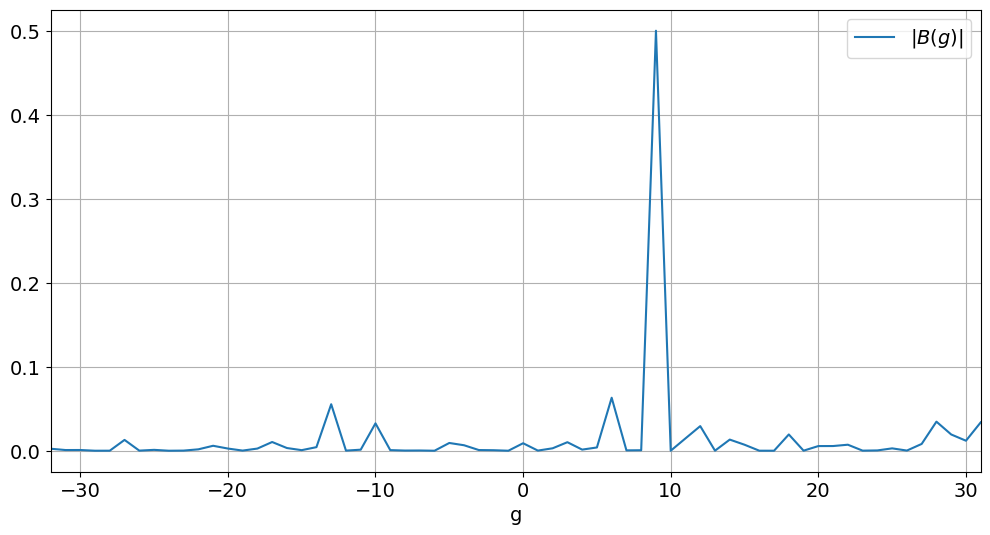

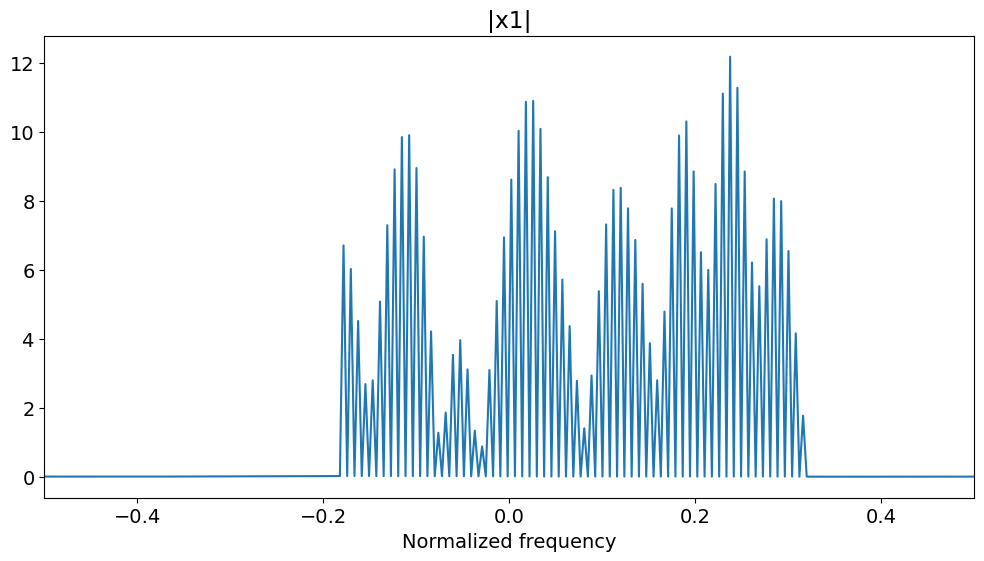

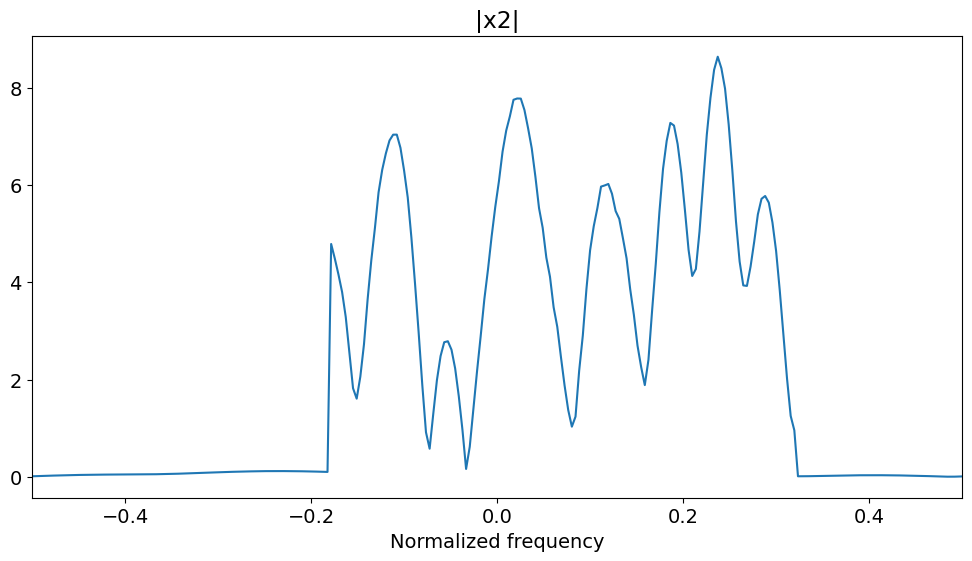

In [13]:
# integer frequency offset estimation and compensation
if signal_detected:
    
    # get symbols in preamble, remove CP
    s1_est = y[ t_est : t_est + N_ofdm ]  
    s2_est = y[ t_est + N_ofdm + L_G : t_est + 2 * N_ofdm + L_G]
    
    # to frequency regima
    x1 = np.fft.fftshift( np.fft.fft( s1_est ) )  
    x2 = np.fft.fftshift( np.fft.fft( s2_est ) ) 

    # get B(g) 
    E_x2 = np.linalg.norm( x2 )**2
    possible_offsets = range( -( N_ofdm-N_used )//2//2, ( N_ofdm - N_used ) //2//2, 1 ) 

    v = np.sqrt(2)* c_2[::2] / c_1
    
    k = np.concatenate( ( np.arange( -N_used // 2, 0, 2 ), np.arange( 2, N_used//2, 2) ) ) + N_ofdm//2
    v_nodc = np.delete( v, N_used//2//2 )

    B = np.zeros( len(possible_offsets ), dtype=complex )
    for i, g in enumerate( possible_offsets ):
        B[ i ] = ( np.abs( np.sum( np.conj( x1[ k + 2 * g ] ) * np.conj( v_nodc ) * x2[ k + 2 * g ]) )**2 ) / (2*E_x2**2)

    # determine integer frequency offset
    g_est = np.argmax( B )
    f_est_I = 2 * g_est - ( N_ofdm - N_used ) // 2
    print("Estimated integer frequency offset: {}".format( f_est_I ) )
    
    print("Estimated frequency offset (integer + fractional): " + str(f_est_I + f_est_frac))
    plt.plot(possible_offsets, np.abs(B), label="$|B(g)|$")
    plt.xlabel("g"); plt.xlim([possible_offsets[0], possible_offsets[-1]]); 
    plt.grid(1); plt.legend(); plt.show()

    f = np.linspace( -.5, .5, N_ofdm )
    plt.plot(f, np.abs(x1)); plt.title("|x1|"); plt.xlabel("Normalized frequency"); plt.xlim([f[0], f[-1]]); plt.show()
    plt.plot(f, np.abs(x2)); plt.title("|x2|"); plt.xlabel("Normalized frequency"); plt.xlim([f[0], f[-1]]); plt.show()
